## Real Estate Agents Project - Langchain
This is a notebook that contains the experimentation of real estate agents using Langchain.


Install packages

In [1]:
!pip install -q langchain-google-genai langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 1.3 MB/s eta 0:00:00


Import libraries

In [2]:
import os
import io
import requests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import panel as pn
import sqlalchemy
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import google.generativeai as genai
from collections import defaultdict
from langchain.tools import BaseTool, tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.agents import create_sql_agent, initialize_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.agents.agent_types import AgentType
from langchain.sql_database import SQLDatabase
from langchain.prompts.chat import ChatPromptTemplate
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Set up environment
os.environ['GOOGLE_API_KEY'] = 'GOOGLE API KEY'
genai.configure(api_key = os.environ['GOOGLE_API_KEY'])

Build SQL agent using create_sql_agent

In [4]:
user_query = '''I want a house with up to 3 bedrooms and 3 bathrooms in the city of Yuba,
California and spend no more than $600,000.  I want the front yard to have a white fence and the building to be two stories.'''

In [5]:
def get_completion_from_messages(messages):
  model = ChatGoogleGenerativeAI(model='gemini-pro',
                                  temperature=1)
  response = model(messages)
  return response.content

def get_data_requirement(user_query):
  sql = f''' Extract SQL requirement from {user_query} in one line, only including following information:
  bedrooms and bathrooms,
  location (it can be separate city or state or both, convert state to abbreviated format; if location is Yuba, it means 'Yuba City'),
  square feet,
  price range (any number start with "$" is price, should remove '$', must be format like this 'price range $0-500,000', if user mentions the word 'around', you add/subtract 30% from the amount), other information is not acceptable.
  You should include some word such as up to, less than, no more than or at least in the ouput to make sure extract enough information.
  Each information is separated by a comma.
  '''

  clip = f''' Only extract one, some or all following information from {user_query}:
  amenities (home appliances, pool, story house (one story house, two stories house,...), yard (front yard, back yard, yard with specific requirement such as yard with big tree,...) and aesthetic (interior, exterior).
  Each information is separated by a comma.
  Don't include bedroom, bathroom, location, square feet and price in the output.
  '''
  requirement_sql = get_completion_from_messages([HumanMessage(content = sql)])
  requirement_clip = get_completion_from_messages([HumanMessage(content = clip)])

  return [requirement_sql, requirement_clip]

requirement = get_data_requirement(user_query)

engine = sqlalchemy.create_engine('sqlite:///housing.db')
metadata = sqlalchemy.MetaData()
house = sqlalchemy.Table('house', metadata)
df = pd.read_csv('https://github.com/fellowship/real-estate-agent/blob/main/sample_datasets/cleaned_houses_info_with_ID.csv')
df.to_sql('house', engine, if_exists='replace', index=False)
database = SQLDatabase(engine)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest",
                             temperature=0)
sql_toolkit=SQLDatabaseToolkit(db=database,
                               llm=llm)

 # Write prompt to give context to llm
prompt = ChatPromptTemplate.from_messages(
    [("system",
        """
        You are a very intelligent AI assistant who is expert in identifying relevant information for user requirement and
        converting into SQL queries to generate correct answer.
        The output must be a list of dictionary including adequate data from ID, bedrooms, bathrooms, living_space, price and address columns.
        If you can't find answer in the database, return 'no data match requirement'
        Context:
        You must query against the connected database, it has only 1 table house.
        House table has ID, bedrooms, bathrooms, living_space, city, state, zipcode, latitude, longitude, property_url and price columns.
        """
        ),
        ("user","{question}\ ai: "),
    ])

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [6]:
# Create SQL agent and get the result
agent_sql = create_sql_agent(llm=llm,
                            toolkit=sql_toolkit,
                            agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                            verbose=False,
                            max_execution_time=5000,
                            max_iterations=2000,
                            handle_parsing_errors=True)
result_sql = agent_sql.invoke(prompt.format_prompt(question = requirement[0]))
result_sql

{'input': ChatPromptValue(messages=[SystemMessage(content="\n        You are a very intelligent AI assistant who is expert in identifying relevant information for user requirement and\n        converting into SQL queries to generate correct answer.\n        The output must be a list of dictionary including adequate data from ID, bedrooms, bathrooms, living_space, price and address columns.\n        If you can't find answer in the database, return 'no data match requirement'\n        Context:\n        You must query against the connected database, it has only 1 table house.\n        House table has ID, bedrooms, bathrooms, living_space, city, state, zipcode, latitude, longitude, property_url and price columns.\n        "), HumanMessage(content='Bedrooms up to 3, Bathrooms up to 3, Yuba City, CA, Price range $0-600,000\\ ai: ')]),
 'output': "[{'ID': 317, 'bedrooms': 3, 'bathrooms': 2, 'living_space': 2330.0, 'price': 575000.0, 'address': '373 2nd St, Yuba City, CA 95991'}, {'ID': 319, '

In [7]:
# Convert SQL agent result into dataframe
output = eval(result_sql['output'])
index = [d.get('ID', None) for d in output]
data = pd.DataFrame(output, index = index)
data

,ID,bedrooms,bathrooms,living_space,price,address
317,317,3,2,2330.0,575000.0,"373 2nd St, Yuba City, CA 95991"
319,319,3,2,1634.0,450000.0,"2366 Arizona Way, Yuba City, CA 95991"
322,322,3,2,1524.0,270000.0,"1640 Melanie Ln, Yuba City, CA 95991"
324,324,3,2,2304.0,520000.0,"1145 Ashwood Ct, Yuba City, CA 95991"
326,326,2,1,864.0,169900.0,"799 Clark Ave APT 26, Yuba City, CA 95991"
327,327,3,2,1599.0,439000.0,"1441 Tradewind Dr, Yuba City, CA 95991"
328,328,2,1,1115.0,325000.0,"533 Scott St, Yuba City, CA 95991"
329,329,3,2,1397.0,315000.0,"795 Railroad Ave, Yuba City, CA 95991"
330,330,3,2,1629.0,449000.0,"1890 Ari Ct, Yuba City, CA 95991"
331,331,3,3,1444.0,389000.0,"1094 Arbor Dr, Yuba City, CA 95991"


Build CLIP agent

In [8]:
# Load dataset
df_image = pd.read_parquet('https://github.com/fellowship/real-estate-agent/blob/main/sample_datasets/df_image.parquet')
df_image['img_embeddings'] = df_image['img_embeddings'].apply(lambda x: x.reshape(1,-1))
df_image.rename(columns={'property_id': 'ID'}, inplace=True)

In [9]:
# Create model and tokenizer
model_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_ID)
tokenizer = CLIPTokenizer.from_pretrained(model_ID)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

In [10]:
# Create function to calculate cosine similarity, then plot images
# CLIP for single query
L = data['ID'].tolist()
def clip(single_query):
  frames = [df_image[df_image['ID']==i] for i in L]
  df = pd.concat(frames)
  # Create CLIP text embedding for a single text.
  inputs = tokenizer(single_query, return_tensors = "pt")
  text_embeddings = model.get_text_features(**inputs)
  embedding_as_np = text_embeddings.detach().numpy()

  # Calculate cosine similarity
  df['cos'] = df['img_embeddings'].apply(lambda x: cosine_similarity(embedding_as_np, x))
  df['cos'] = df['cos'].apply(lambda x: x[0][0])
  df = df.sort_values(by='cos', ascending=False)

  # Plot top k images
  top_images = df.iloc[:3,:]
  n_row, n_col = 1, 3
  _, axs = plt.subplots(n_row, n_col, figsize=(12, 5))
  axs = axs.flatten()
  _.suptitle(single_query, fontsize=12)
  for img, ax, caption, ID, sim_score in zip(top_images['image'], axs, top_images['caption'], top_images['ID'], top_images['cos']):
      r = requests.get(img, stream=True)
      image = Image.open(io.BytesIO(r.content))
      ax.imshow(image)
      ax.title.set_text(f'Caption: {caption}\npID: {ID}\nSimilarity: {sim_score:.2f}')
      ax.title.set_size(8)

  # New rank
  new = df['ID'].tolist()
  lst = list(dict.fromkeys(new))
  keys = [str(k) for k in lst]
  values = [i for i in range(1, len(lst)+1)]
  result_dict = {}
  for j in range(len(keys)):
    result_dict[keys[j]] = values[j]
  return result_dict

In [11]:
# CLIP for multiple queries
def final_clip(clip_query):
  list_of_dicts = []
  for i in clip_query.split(', '):
    res = clip(i)
    list_of_dicts.append(res)
  # Create a defaultdict to accumulate sums
  sum_dict = defaultdict(int)

  # Sum the values with the same keys
  for d in list_of_dicts:
    for key, value in d.items():
        sum_dict[key] += value

  # Convert back to regular dictionary
  sum_dict = dict(sum_dict)
  keys = list(sum_dict.keys())
  values = list(sum_dict.values())
  sorted_value_index = np.argsort(values)
  sorted_dict = {keys[i]:values[i] for i in sorted_value_index}
  final = [int(i) for i in list(sorted_dict.keys())]
  return final

In [12]:
# Create tools
class ExtractImageTool(BaseTool):
    name = "Extract ID Tool"
    description = 'use this tool to extract ID list based on clip query.'

    def _run(self, clip_query: str):
        description = final_clip(clip_query)
        return description

    def _arun(self, clip_query: str):
        raise NotImplementedError("Async operation not supported yet")

tools_clip = [ExtractImageTool()]

In [13]:
# Create CLIP agent
agent_clip = initialize_agent(
    agent = None,
    tools=tools_clip,
    llm=llm,
    verbose=False,
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


{'input': 'Return ID list that match to Two stories house, front yard with white fence',
 'output': '[345, 378, 336, 383, 376, 343, 379, 327, 339, 367, 346, 340, 319, 363, 344, 317, 322, 333, 328, 334, 365, 329, 342, 384, 377, 326, 349, 368, 358, 324, 330, 355, 359, 371, 362, 372, 357, 382, 369, 351, 331, 353]'}

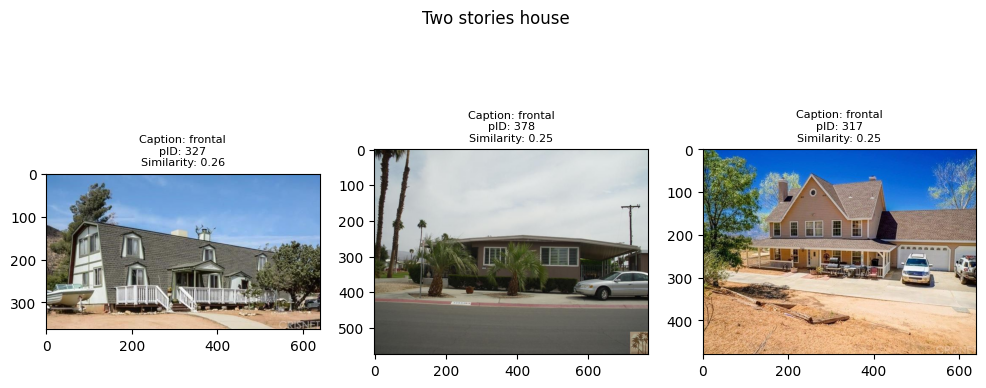

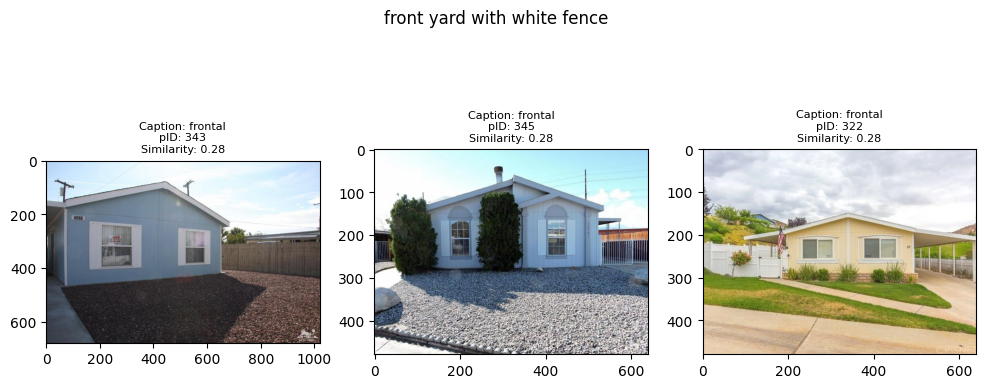

In [14]:
# Get result for CLIP agent
clip_query = requirement[1]
result_clip = agent_clip.invoke(f'Return ID list that match to {clip_query}')
result_clip

In [15]:
result_clip['output']

'[345, 378, 336, 383, 376, 343, 379, 327, 339, 367, 346, 340, 319, 363, 344, 317, 322, 333, 328, 334, 365, 329, 342, 384, 377, 326, 349, 368, 358, 324, 330, 355, 359, 371, 362, 372, 357, 382, 369, 351, 331, 353]'

Build reranking agent

In [16]:
def rerank(query):
  def embed(text):
    inputs = tokenizer(text, return_tensors = 'pt')
    text_embeddings = model.get_text_features(**inputs)
    embedding_as_np = text_embeddings.detach().numpy()
    return embedding_as_np
  sep = query.split(', ')
  sql_query = ', '.join(sep[:-1])
  clip_query = sep[-1]
  sql_embedding = embed(sql_query)
  clip_embedding = embed(clip_query)
  query_embedding = np.concatenate([sql_embedding, clip_embedding], axis=1)

  frames = df_image[df_image['ID'].isin(L)]

  # Get data from SQL agent according to number of images (because each record has 4 images)
  l = []
  for i in range(data.shape[0]):
    tempt = []
    for j in data.iloc[i,:]:
      tempt.append(str(j))
    l.append(', '.join(tempt))
  records = [x for x in l for _ in range(4)]

  # Embed the SQL records
  record_embeddings = []
  for record in records:
    record_embedding = embed(record)
    record_embeddings.append(record_embedding.reshape(1,-1))
  record_image_embeddings = list(frames['img_embeddings'])

  # Concatenate sql and image vectors
  con = [np.concatenate((a, b), axis = 1) for a, b in zip(record_embeddings, record_image_embeddings)]
  # Calculate cosine similarity matrix
  cos_sim_matrix = [cosine_similarity(query_embedding, s) for s in con]
  # Sort by cosine similarity score
  new_frames=frames.copy()
  new_frames['cos_simi'] = cos_sim_matrix
  new_frames['cos_simi'] = new_frames['cos_simi'].apply(lambda x: x[0][0])
  new_ = new_frames.sort_values(by='cos_simi', ascending=False)

  # Reranking
  rank = new_['ID'].tolist()
  lst = list(dict.fromkeys(rank))
  keys = [str(k) for k in lst]
  values = [i for i in range(1, len(lst)+1)]
  result_dict = {}
  for j in range(len(keys)):
    result_dict[keys[j]] = values[j]
  return result_dict

In [17]:
def final_rerank(req):
  n = len(requirement[1].split(', '))
  list_of_dicts = []
  for i in range(1, n +1):
    sep = req.split(', ')
    l = ', '.join(sep[:-n]) + ', ' + sep[-i]
    res = rerank(l)
    list_of_dicts.append(res)

  # Create a defaultdict to accumulate sums
  sum_dict = defaultdict(int)

  # Sum the values with the same keys
  for d in list_of_dicts:
    for key, value in d.items():
        sum_dict[key] += value

  # Convert back to regular dictionary
  sum_dict = dict(sum_dict)
  keys = list(sum_dict.keys())
  values = list(sum_dict.values())
  sorted_value_index = np.argsort(values)
  sorted_dict = {keys[i]:values[i] for i in sorted_value_index}
  # Rerank data
  rerank_list = [int(i) for i in list(sorted_dict.keys())]
  rerank_data = data.reindex(rerank_list).iloc[:10,:]
  return rerank_data

In [18]:
# Create tools
class ExtractRerankTool(BaseTool):
  name = 'Extract rerank data'
  description = 'use this tool to extract top rerank based on user query.'

  def _run(self, req: str):
      description = final_rerank(req)
      return description

  def _arun(self, req: str):
      raise NotImplementedError('Async operation not supported yet')

tools_rerank = [ExtractRerankTool()]

In [19]:
# Create rerank agent
agent_rerank = initialize_agent(
    agent = None,
    tools=tools_rerank,
    llm=llm,
    verbose=True,
    handle_parsing_errors=True
)

In [24]:
# Run rerank agent and get result of top 10 houses
req = ', '.join(requirement)
result_final = agent_rerank.invoke(f'Return rerank data that match to {req} in human-readable manner.')
result_final



> Entering new AgentExecutor chain...
Thought: I need to extract rerank data using the provided tool to answer this question. 
Action: Extract rerank data
Action Input: Bedrooms up to 3, Bathrooms up to 3, Yuba City, CA, Price range $0-600,000, Two stories house, front yard with white fence
Observation:       ID  bedrooms  bathrooms  living_space     price  \
322  322         3          2        1524.0  270000.0   
362  362         3          2        1420.0  410000.0   
377  377         3          2        1396.0  389000.0   
365  365         3          2        1452.0  420000.0   
336  336         3          2        1419.0  429900.0   
346  346         3          3        1730.0  300000.0   
327  327         3          2        1599.0  439000.0   
317  317         3          2        2330.0  575000.0   
344  344         3          3        1556.0  455000.0   
384  384         3          2        1309.0  359900.0   

                                        address  
322        1640

{'input': 'Return rerank data that match to Bedrooms up to 3, Bathrooms up to 3, Yuba City, CA, Price range $0-600,000, Two stories house, front yard with white fence in human-readable manner.',
 'output': 'Here are some properties matching your criteria:\n\n* **1640 Melanie Ln, Yuba City, CA 95991:** 3 bedrooms, 2 bathrooms, 1524 sqft, $270,000\n* **126 River Oaks Dr, Yuba City, CA 95991:** 3 bedrooms, 2 bathrooms, 1420 sqft, $410,000\n* **1052 Courtyard Dr, Yuba City, CA 95991:** 3 bedrooms, 2 bathrooms, 1396 sqft, $389,000\n* **1653 Southpark Dr, Yuba City, CA 95991:** 3 bedrooms, 2 bathrooms, 1452 sqft, $420,000\n* **900 Oakview Dr, Yuba City, CA 95991:** 3 bedrooms, 2 bathrooms, 1419 sqft, $429,900\n* **750 Lincoln Rd APT 20, Yuba City, CA 95991:** 3 bedrooms, 3 bathrooms, 1730 sqft, $300,000\n* **1441 Tradewind Dr, Yuba City, CA 95991:** 3 bedrooms, 2 bathrooms, 1599 sqft, $439,000\n* **373 2nd St, Yuba City, CA 95991:** 3 bedrooms, 2 bathrooms, 2330 sqft, $575,000\n* **2152 Deer